In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np
import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, Image, display, HTML
import tensorflow as tf
import tensorflow_hub as hub
import sklearn.metrics as sk_metrics
import time
from keras.applications import xception
from keras.utils.vis_utils import plot_model
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, layers, models
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.layers import Dense,Flatten,GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
## set train, validation, and test paths
train_path = '../input/datasetfinal/dataset70-10-20/train'
validation_path = '../input/datasetfinal/dataset70-10-20/val'
test_path = '../input/datasetfinal/dataset70-10-20/test'
classes= ['Fruit', 'Packages', 'Vegetables']

In [3]:
train_batches  = ImageDataGenerator().flow_from_directory(
    train_path, target_size=(224,224), classes = classes, batch_size = 50)

validation_batches  = ImageDataGenerator().flow_from_directory(
    validation_path, target_size=(224,224), classes = classes, batch_size = 10)

test_batches  = ImageDataGenerator().flow_from_directory(
    test_path, target_size=(224,224), classes = classes, batch_size = 10)

Found 3770 images belonging to 3 classes.
Found 508 images belonging to 3 classes.
Found 1156 images belonging to 3 classes.


In [4]:
#take a look at output of the generators
for data_batch, labels_batch in train_batches:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (50, 224, 224, 3)
labels batch shape: (50, 3)


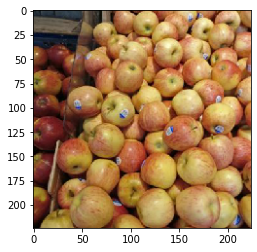

In [5]:
##Sample images
img_path = '../input/datasetfinal/dataset70-10-20/train/Fruit/Royal-Gala/Royal-Gala_001 (2).jpg' 
img = image.load_img(img_path, target_size=(224,224))
plt.imshow(img)

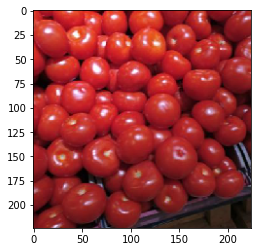

In [6]:
img_path = '../input/datasetfinal/dataset70-10-20/train/Vegetables/Regular-Tomato/Regular-Tomato_001 (2).jpg' 
img = image.load_img(img_path, target_size=(224,224))
plt.imshow(img)

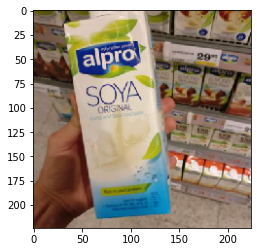

In [7]:
img_path = '../input/datasetfinal/dataset70-10-20/train/Packages/Alpro-Shelf-Soy-Milk/Alpro-Shelf-Soy-Milk_001 (2).jpg' 
img = image.load_img(img_path, target_size=(224,224))
plt.imshow(img)

## Data Augmentation

In [8]:
## Augmentation datagenerator
train_datagen_aug = ImageDataGenerator(
        shear_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        horizontal_flip=True)

## train generator
train_generator_aug = train_datagen_aug.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=25,
        class_mode='categorical')

## test generator, required for prediction
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=1,
        shuffle = False,
        class_mode='categorical')

## validation generator
val_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

Found 3770 images belonging to 3 classes.
Found 1156 images belonging to 3 classes.
Found 508 images belonging to 3 classes.


In [9]:
## set steps per epoch for train
train_filenames = train_generator_aug.filenames
steps_train = len(train_filenames)/train_generator_aug.batch_size

## set steps per epoch for validation
val_filenames = val_generator.filenames
steps_val = len(val_filenames)/val_generator.batch_size

## test
filenames_test = test_generator.filenames
nb_samples_test= len(filenames_test)
true_classes = test_generator.classes
target_names = classes

# Xception

In [10]:
model = xception.Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3),classes=3,pooling='avg')
print (model.summary())

2022-01-05 08:09:11.285471: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 08:09:11.409276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 08:09:11.410346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 08:09:11.412122: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

83697664/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________

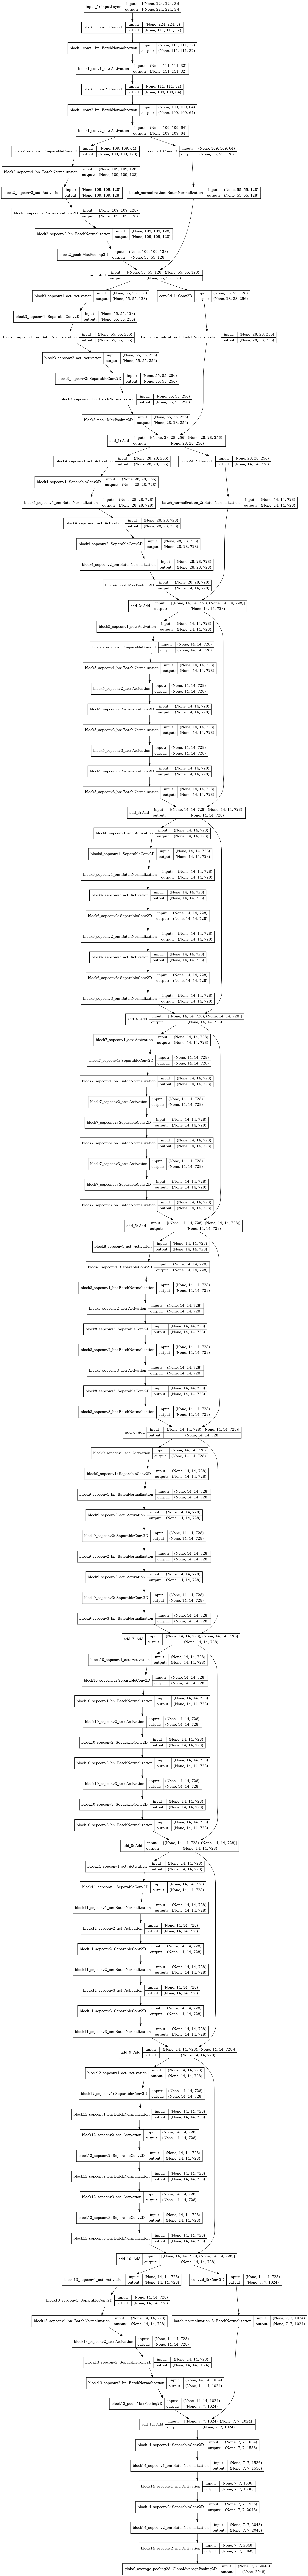

In [11]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [12]:
count = 0
for layer in model.layers:
    count += 1
count

133

In [13]:
for layer in model.layers:
    layer.trainable = False

In [14]:
x=model.output
x=tf.keras.layers.Dropout(.2)(x)
output=Dense(3,activation='softmax')(x)
base_xception=Model(model.input,output)

In [15]:
base_xception.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['acc'])

# Callbacks
es = EarlyStopping(monitor='val_accuracy', min_delta=0.01,patience= 5, verbose=1)
mc = ModelCheckpoint("./base_best.h5", monitor='val_accuracy', verbose=1, save_best_only=True)
cb=[es, mc]

fit_generator = base_xception.fit(train_generator_aug,
                                   steps_per_epoch=steps_train,
                                    epochs=50,
                                    validation_data=val_generator,
                                    validation_steps=steps_val,
                                    verbose=1,
                                    callbacks=cb)

2022-01-05 08:09:20.429804: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-01-05 08:09:25.213963: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


150/150 [==============================] - 86s 506ms/step - loss: 0.5909 - acc: 0.7939 - val_loss: 0.3641 - val_acc: 0.8740
Epoch 2/50
150/150 [==============================] - 58s 388ms/step - loss: 0.2884 - acc: 0.9005 - val_loss: 0.2431 - val_acc: 0.9232
Epoch 3/50
150/150 [==============================] - 54s 357ms/step - loss: 0.2156 - acc: 0.9249 - val_loss: 0.1984 - val_acc: 0.9390
Epoch 4/50
150/150 [==============================] - 54s 358ms/step - loss: 0.1848 - acc: 0.9326 - val_loss: 0.1732 - val_acc: 0.9449
Epoch 5/50
150/150 [==============================] - 54s 357ms/step - loss: 0.1652 - acc: 0.9403 - val_loss: 0.1560 - val_acc: 0.9469
Epoch 6/50
150/150 [==============================] - 52s 344ms/step - loss: 0.1472 - acc: 0.9501 - val_loss: 0.1451 - val_acc: 0.9449
Epoch 7/50
150/150 [==============================] - 54s 357ms/step - loss: 0.1376 - acc: 0.9544 - val_loss: 0.1348 - val_acc: 0.9488
Epoch 8/50
150/150 [==============================] - 53s 353ms/st

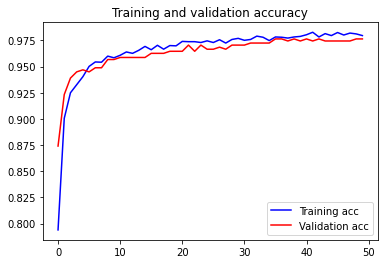

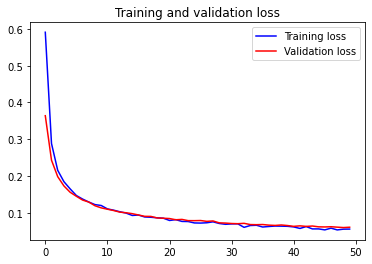

In [16]:
acc = fit_generator.history['acc']
val_acc = fit_generator.history['val_acc']
loss = fit_generator.history['loss']
val_loss = fit_generator.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc,'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [17]:
base_xception.save('groceries_base_model.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [18]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(base_xception)
tflite_model = converter.convert()

# Save the model.
with open('base_model_xception.tflite', 'wb') as f:
    f.write(tflite_model)

2022-01-05 08:57:06.161250: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-01-05 08:57:22.073363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 08:57:22.073843: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-01-05 08:57:22.073994: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-01-05 08:57:22.074629: I tensorflow/stream_executor/cuda/cuda_gpu_executor.

## Predict on test data

In [19]:
base_pred= base_xception.predict(test_generator, steps = nb_samples_test, verbose=2)
base_pred= base_pred.argmax(axis=1)

1156/1156 - 15s


[Text(0, 0.5, 'Fruit'), Text(0, 1.5, 'Packages'), Text(0, 2.5, 'Vegetables')]

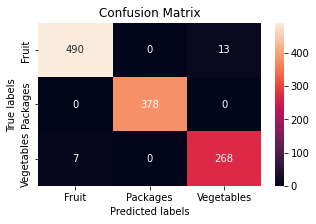

In [20]:
cm = confusion_matrix(base_pred, true_classes)
f, ax= plt.subplots(1,1,figsize=(5,3))
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(classes) 
ax.yaxis.set_ticklabels(classes)

In [21]:
print(classification_report(true_classes, base_pred, target_names=target_names))

              precision    recall  f1-score   support

       Fruit       0.97      0.99      0.98       497
    Packages       1.00      1.00      1.00       378
  Vegetables       0.97      0.95      0.96       281

    accuracy                           0.98      1156
   macro avg       0.98      0.98      0.98      1156
weighted avg       0.98      0.98      0.98      1156

